In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
from astroML.datasets import fetch_rrlyrae_mags

data = fetch_rrlyrae_mags()  
# number of objects in dataset

data = data.byteswap().newbyteorder()

df = pd.DataFrame(data)
df.head()

,__SIG2010_,Type,Per,uAmp,T0_u,gAmp,T0_g,rAmp,T0_r,iAmp,...,RAJ2000,DEJ2000,Ar,Dist,umag,gmag,rmag,imag,zmag,Vmag
0,4099,b'ab',0.641754,0.534608,51075.274714,0.563839,51075.288902,0.398326,51075.295112,0.317851,...,0.935679,1.115859,0.089,17.750000,18.134001,16.989000,16.777000,16.702999,16.684999,16.846001
1,13350,b'ab',0.547987,1.029445,54025.330112,1.093322,54025.326856,0.801720,54025.326474,0.642111,...,0.283437,1.178522,0.080,24.770000,18.839001,17.679001,17.544001,17.497000,17.500999,17.570000
2,15927,b'ab',0.612263,0.651579,53680.222485,0.697439,53680.229439,0.486554,53680.226214,0.368674,...,3.254658,-0.584066,0.090,29.120001,19.288000,18.058001,17.858999,17.792000,17.780001,17.921000
3,20406,b'ab',0.631853,0.553247,54000.280528,0.586784,54000.292109,0.426846,54000.276631,0.342734,...,3.244369,0.218891,0.088,9.130000,16.715000,15.543000,15.336000,15.286000,15.276000,15.403000
4,21992,b'ab',0.625880,1.109322,53698.245218,1.139930,53698.245256,0.849551,53698.243534,0.661144,...,4.315354,1.054582,0.077,7.350000,16.186001,15.040000,14.909000,14.864000,14.853000,14.932000


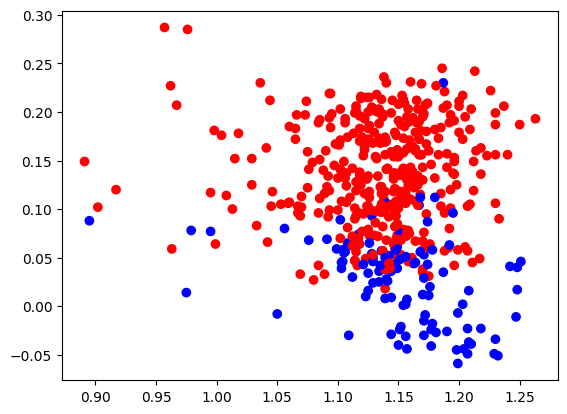

In [15]:
df['u-g'] = df['umag'] - df['gmag']
df['g-r'] = df['gmag'] - df['rmag']
df['r-i'] = df['rmag'] - df['imag']
df['i-z'] = df['imag'] - df['zmag']

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'))

In [16]:
A = df[df['Type']==b'ab'][['u-g', 'g-r']].values

def phi(u):
    return sum(u[i]*np.dot(A[i].T, A[i])for i in range(len(u))) - np.dot(sum(u[i]*A[i] for i in range(len(u))).T,sum(u[i]*A[i] for i in range(len(u))))

def e(idx):
    vec = np.zeros(len(A))
    vec[idx] = 1
    return vec

In [17]:
A = df[df['Type']==b'ab'][['u-g', 'g-r']].values

epsilon = 0.001
distances_to_a_1 = np.linalg.norm(A - A[0], axis=1)**2  # ||a_i - a_1||^2
alpha = np.argmax(distances_to_a_1)
distances_to_a_alpha = np.linalg.norm(A - A[alpha], axis=1)**2  if alpha is not None else np.zeros(len(A))  # ||a_i - a_α||^2
beta = np.argmax(distances_to_a_alpha)

u = np.zeros(len(A))
u[alpha] = 0.5
u[beta] = 0.5

chi = [A[alpha], A[beta]]
c = sum(u[i] * A[i] for i in range(len(A)))

mu = phi(u)

distances_to_c = np.linalg.norm(A - c, axis=1)**2
kappa = np.argmax(distances_to_c)

lambd= np.zeros(len(A))

delta = (distances_to_c[kappa]/mu)-1.0

k = 0

while delta > ((1 + epsilon)**2) - 1.0 and k < 1000:
    lambd = delta/(2*(1.0+delta))
    k = k + 1

    # Calculate away-step direction
    distances_to_c_minus_kappa = distances_to_c - distances_to_c[kappa]
    away_direction = np.argmin(distances_to_c_minus_kappa)

    u = (1-lambd)*u + lambd*e(kappa)
    c = (1-lambd)*c + lambd*A[kappa]
    chi.append(A[kappa])
    mu = phi(u)
    distances_to_c = np.linalg.norm(A - c, axis=1)**2
    kappa = np.argmax(distances_to_c)
    delta = (distances_to_c[kappa]/mu)-1

print(c)
print(chi)
print
print(np.sqrt((1+delta)*mu))
print(k)

ValueError: operands could not be broadcast together with shapes (379,) (2,) 

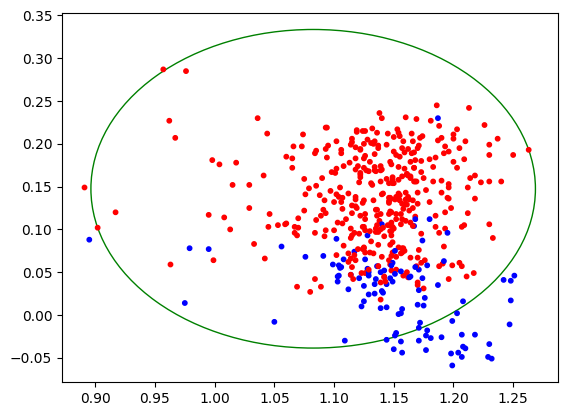

In [19]:
circle = plt.Circle(tuple(c), np.sqrt(mu), color='g', fill=False)

ax = plt.gca()
ax.cla()

ax.add_patch(circle)

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'), s=10)